⚠️  index 3 skipped (no mapped services)
⚠️  index 16 skipped (no mapped services)
⚠️  index 29 skipped (no mapped services)
⚠️  index 30 skipped (no mapped services)
⚠️  index 45 skipped (no mapped services)
⚠️  index 50 skipped (no mapped services)
⚠️  index 53 skipped (no mapped services)
⚠️  index 73 skipped (no mapped services)
⚠️  index 86 skipped (no mapped services)
⚠️  index 98 skipped (no mapped services)
⚠️  index 103 skipped (no mapped services)
⚠️  index 115 skipped (no mapped services)
⚠️  index 131 skipped (no mapped services)
⚠️  index 146 skipped (no mapped services)
⚠️  index 159 skipped (no mapped services)
⚠️  index 160 skipped (no mapped services)
⚠️  index 167 skipped (no mapped services)
⚠️  index 185 skipped (no mapped services)
⚠️  index 191 skipped (no mapped services)
⚠️  index 193 skipped (no mapped services)
⚠️  index 197 skipped (no mapped services)
⚠️  index 200 skipped (no mapped services)
⚠️  index 207 skipped (no mapped services)
⚠️  index 213 skipped 

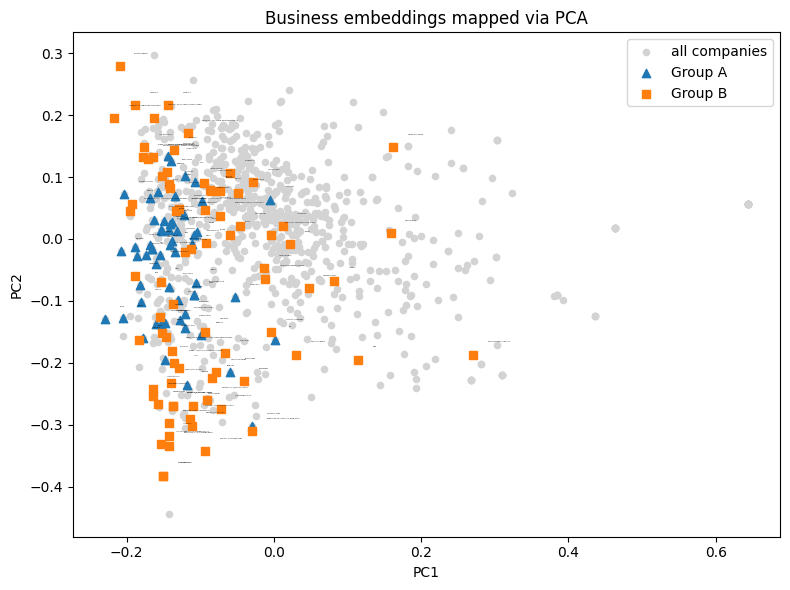

In [96]:
import os
import ast
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# ————————————————————————————  
# 1) Read your original business data  
# ————————————————————————————  
BUSINESS_CSV = "Merged_LinkedIn_Sort_Clean_Cleaned_cleaned.csv"   # adjust as needed
df_bus = pd.read_csv(BUSINESS_CSV)
service_cols = [f"service_{i}" for i in range(1,25)]

# Ensure you have a 'name' column:
if 'name' not in df_bus.columns:
    raise KeyError("Expected a 'name' column in your business CSV.")

# ————————————————————————————  
# 2) Read your service embeddings  
# ————————————————————————————  
EMB_CSV = "embeddings_output.csv"
df_emb = pd.read_csv(EMB_CSV)
df_emb["vec"] = df_emb["embedding"].apply(ast.literal_eval).apply(np.array)
service_to_vec = dict(zip(df_emb["text"], df_emb["vec"]))

# ————————————————————————————  
# 3) Build each company’s vector, skipping empty ones  
# ————————————————————————————  
company_vecs = []
company_indices = []  # tracks original df index

for idx, row in df_bus.iterrows():
    svcs = [row[c] for c in service_cols if pd.notna(row[c]) and row[c] in service_to_vec]
    if not svcs:
        continue
    vecs = [service_to_vec[s] for s in svcs]
    company_vecs.append(np.mean(vecs, axis=0))
    company_indices.append(idx)

all_company_mat = np.vstack(company_vecs)

# ————————————————————————————  
# 4) Fit PCA → 2D  
# ————————————————————————————  
pca = PCA(n_components=2, random_state=42)
coords_2d = pca.fit_transform(all_company_mat)

# Map original row idx → 2D coords
company_coords = {
    orig_idx: tuple(coord)
    for orig_idx, coord in zip(company_indices, coords_2d)
}

# ————————————————————————————  
# 5) Plot helper (labels with business name)  
# ————————————————————————————  
def plot_businesses(row_indices, label=None, marker="o"):
    xs, ys = [], []
    for idx in row_indices:
        if idx not in company_coords:
            print(f"⚠️  index {idx} skipped (no mapped services)")
            continue
        x, y = company_coords[idx]
        xs.append(x); ys.append(y)
        # Use the 'name' column value for the label
        name = df_bus.at[idx, 'name']
        plt.text(x + 0.02, y + 0.02, name, fontsize=1)
    plt.scatter(xs, ys, marker=marker, label=label)

# ————————————————————————————  
# 6) Demo usage  
# ————————————————————————————  
if __name__ == "__main__":
    plt.figure(figsize=(8,6))
    # background layer: all companies in light gray
    all_xs, all_ys = zip(*company_coords.values())
    plt.scatter(all_xs, all_ys, c="lightgray", s=20, label="all companies")

    # e.g., highlight row 5
    #plot_businesses([5], label="Selected Biz", marker="X")

    # e.g., compare two groups
    plot_businesses([0,3,7,8,10,11,12,13,14,15,16,17,18,28,29,30,32,34,38,39,43,44,45,48,50,52,53,64,65,68,70,71,72,73,74,79,81,83,85,86,90,96,98,102,103,107,110,111,114,115,119,120,126,128,130,131,138,140,141,146,151,157,159,165,169,170,176,178,179,187,269,320,417],label="Group A", marker="^")
    plot_businesses([2,
4,
9,
25,
26,
36,
37,
40,
41,
51,
55,
60,
66,
69,
75,
84,
88,
91,
95,
97,
99,
117,
121,
124,
135,
137,
142,
145,
149,
160,
167,
181,
182,
184,
185,
186,
191,
193,
197,
200,
207,
211,
213,
216,
225,
229,
235,
236,
238,
246,
249,
250,
251,
257,
258,
259,
260,
261,
263,
265,
266,
270,
272,
273,
276,
281,
282,
285,
292,
295,
296,
301,
304,
307,
315,
317,
326,
327,
331,
333,
334,
342,
358,
364,
366,
367,
369,
372,
375,
376,
377,
380,
381,
386,
388,
471,
485,
575,
661,
683,
741,
788,
842,
966], label="Group B", marker="s")

    plt.title("Business embeddings mapped via PCA")
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.legend()
    plt.tight_layout()
    plt.show()